In [275]:
import math 

import numpy as np
import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [256]:
datapath = "/media/hemu/Data/mnist/"
global device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [257]:
bs = 128

trn_dset = torchvision.datasets.MNIST(datapath, train=True, download=True,  
                                     transform=torchvision.transforms.ToTensor())
tst_dset = torchvision.datasets.MNIST(datapath, train=False, download=True,
                                     transform=torchvision.transforms.ToTensor())

trn_dloader = torch.utils.data.DataLoader(trn_dset, batch_size=bs, shuffle=True,
                                         num_workers=4)
tst_dloader = torch.utils.data.DataLoader(tst_dset, batch_size=bs, shuffle=True,
                                         num_workers=4)


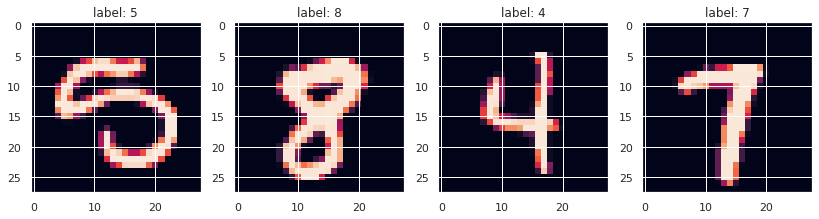

0.0 1.0 0.13315874


In [258]:
trn_loader = iter(trn_dloader)
data = next(trn_loader)
images = data[0].numpy()
fig, ax = plt.subplots(1, 4, figsize=(14, 6))
for i in range(4):
    ax.flatten()[i].imshow(images[i][0])
    ax.flatten()[i].set_title(f"label: {data[1][i].item()}")
plt.show()
print(images.min(), images.max(), images.mean())

In [259]:
def test_accuracy(model, tst_dloader, nlabels=10):
    nlabels = 10
    correct = [0 for i in range(nlabels)]
    total = [0 for i in range(nlabels)]
    tst_loader = iter(tst_dloader)
    model.to(device)
    with torch.no_grad():
        for i, (x, y) in enumerate(tst_loader):
            x=x.to(device)
            out = model(x)
            _, pred = torch.max(out, -1)
            for batch in range(y.shape[0]):
                label = y[batch]
                total[label] += 1
                correct[label] += (pred[batch]==label).squeeze().item()
    return correct, total

In [340]:
def show_predictions(model, x, y):
    model.to(device)
    x = x.to(device)
    with torch.no_grad():
        out = model(x)
        pred = out.max(-1)[1]
    cols = max(int(math.ceil(math.sqrt(x.shape[0]))), 5)
    rows = int(math.ceil(x.shape[0] / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(12, 2*rows))
    _ax = ax.flatten()
    for i in range(x.shape[0]):
        _ax[i].imshow(x.cpu().numpy()[i].squeeze())
        _ax[i].set_title(f"true: {y[i]}" +
                                 f" predicted: {pred[i]}")
        _ax[i].tick_params(which='both', bottom=False, top=False, labelbottom=False,
                          labelleft=False, grid_alpha=0.)
    return fig, ax

## CNN 

In [318]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.out = nn.Linear(20*20*16, 10)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.out( x.view(x.shape[0], -1))
        return x
        

In [319]:
def cnn_trainer(model, trn_dloader):
    model.to(device)
    trn_loader = iter(trn_dloader)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    running_loss = 0.
    epochs = 1
    for i, (x, y) in enumerate(trn_loader):
        opt.zero_grad()
        pred = model(x.to(device))
        loss =  loss_fn(pred, y.to(device))
        loss.backward()
        opt.step()

        _loss = loss.detach().item()
        running_loss += _loss

        if i % 100==0:
            print(f"step: {i} loss: {running_loss}")
            running_loss = 0.

        yield _loss

In [320]:
model_cnn = CNN1()
trainer = iter(cnn_trainer(model_cnn, trn_dloader))
epochs = 1
losses = []
for epoch in range(epochs):
    for loss in trainer:
        losses.append(loss)

step: 0 loss: 2.304473876953125
step: 100 loss: 54.751171588897705
step: 200 loss: 21.398773595690727
step: 300 loss: 14.484878655523062
step: 400 loss: 11.529253177344799


Total Accuracy:  97.42
Accuracy for class 1: 98.87755102040816
Accuracy for class 2: 99.11894273127753
Accuracy for class 3: 95.25193798449612
Accuracy for class 4: 98.41584158415841
Accuracy for class 5: 98.57433808553971
Accuracy for class 6: 94.73094170403587
Accuracy for class 7: 98.12108559498957
Accuracy for class 8: 96.88715953307393
Accuracy for class 9: 98.15195071868582
Accuracy for class 10: 95.73835480673935


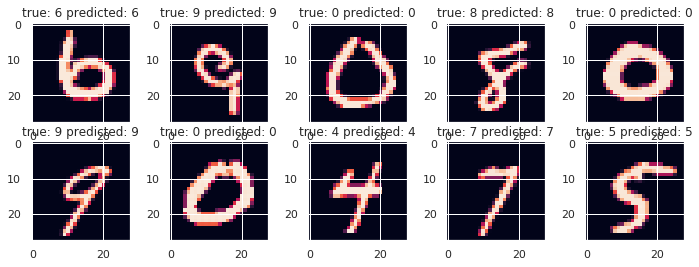

In [321]:
correct, total = test_accuracy(model_cnn, tst_dloader)
print("Total Accuracy: ", 100*sum(correct)/sum(total))
for i in range(10):
    print(f"Accuracy for class {i+1}: {100*correct[i]/total[i]}")
    
x, y = next(iter(tst_dloader))
fig, ax = show_predictions(model_cnn, x[:10], y[:10])

# Linear Model Baseline

In [322]:
class LinearModel(nn.Module):
    def __init__(self, d_input, d_output):
        super().__init__()
        self.layer = nn.Linear(input_len, d_output)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.layer(x)
        return logits

In [323]:
def linear_trainer(model, trn_dloader, lr=1e-3):
    trn_loader = iter(trn_dloader)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    model.to(device)
    running_loss = 0.
    epochs = 1
    for i, (x, y) in enumerate(trn_loader):
        opt.zero_grad()
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss =  loss_fn(pred, y)
        loss.backward()
        opt.step()

        _loss = loss.detach().item()
        running_loss += _loss

        if i % 100==0:
            print(f"step: {i} loss: {running_loss}")
            running_loss = 0.

        yield _loss

In [324]:
trn_loader = iter(trn_dloader)
x, y = next(trn_loader)
x = x.to(device)
input_len = x.shape[1]*x.shape[2]*x.shape[3]
model_linear = LinearModel(input_len, 10).to(device)

In [325]:
epochs=5
losses=[]
for epoch in range(epochs):
    trainer = iter(linear_trainer(model_linear, trn_dloader, lr=1e-3))
    for _loss in trainer:
        losses.append(_loss)
        

step: 0 loss: 2.3503119945526123
step: 100 loss: 125.14548563957214
step: 200 loss: 64.09242317080498
step: 300 loss: 50.40843915939331
step: 400 loss: 44.50848400592804
step: 0 loss: 0.38844022154808044
step: 100 loss: 38.688060998916626
step: 200 loss: 35.086301401257515
step: 300 loss: 34.06457044184208
step: 400 loss: 32.84655974805355
step: 0 loss: 0.3280831277370453
step: 100 loss: 31.248618349432945
step: 200 loss: 30.912107914686203
step: 300 loss: 30.603893354535103
step: 400 loss: 30.651053175330162
step: 0 loss: 0.2323470115661621
step: 100 loss: 29.647330448031425
step: 200 loss: 29.313563600182533
step: 300 loss: 27.156318441033363
step: 400 loss: 29.305610105395317
step: 0 loss: 0.3039564788341522
step: 100 loss: 28.01773415505886
step: 200 loss: 28.307753667235374
step: 300 loss: 28.33337627351284
step: 400 loss: 27.601165860891342


Total Accuracy:  92.3
Accuracy for class 1: 97.95918367346938
Accuracy for class 2: 97.62114537444934
Accuracy for class 3: 87.98449612403101
Accuracy for class 4: 90.1980198019802
Accuracy for class 5: 93.68635437881873
Accuracy for class 6: 86.09865470852019
Accuracy for class 7: 96.34655532359082
Accuracy for class 8: 92.8988326848249
Accuracy for class 9: 89.63039014373716
Accuracy for class 10: 89.59365708622398


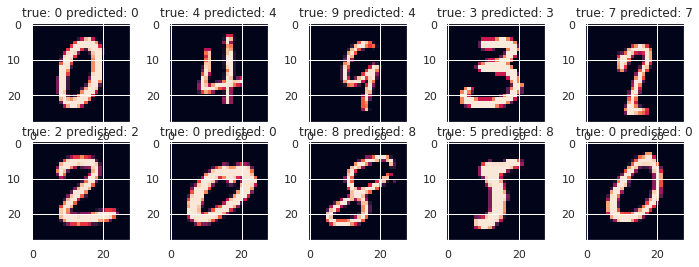

In [327]:
correct, total = test_accuracy(model_linear, tst_dloader)
print("Total Accuracy: ", 100*sum(correct) / sum(total))
for i in range(10):
    print(f"Accuracy for class {i+1}: {100*correct[i]/total[i]}")

x, y = next(iter(tst_dloader))
fig, ax = show_predictions(model_linear, x[:10], y[:10])

# Soft Decision Trees

## Heirarchical Mixture of Experts

In [556]:
class InnerNode(nn.Module):
    """
    Routes to other inner nodes and terminal leaf nodes
    Outputs probability for binary decision (going to left vs right node)
    """
    def __init__(self, d_input, temp=1., parent=None, next_nodes=(None, None)):
        super().__init__()
        if temp is None:
            self.temp = nn.Parameter(torch.tensor(1.), requires_grad=True)
            self.register_parameter("temp", self.temp)
        else:
            self.temp = temp
        self.layer = nn.Linear(d_input, 1, bias=True)
        self.act = nn.Sigmoid()
        self.parent_node = parent
        self.next_nodes = next_nodes
        self.current_p = 1.
    def forward(self, x):
        self.current_p = self.act(self.temp*self.layer(x))
#         self.current_p = p
        return self.current_p

class LeafNodeExpert(nn.Module):
    """
    Expert - outputs a distribution conditioned on input data
    Differs from original paper which has a static distribution - not conditioned on input
    """
    def __init__(self, d_input, d_output, parent=None):
        super().__init__()
        self.layer = nn.Linear(d_input, d_output)
        self.act = nn.Softmax(dim=-1) # not needed if using nn.CrossEntropyLoss
        self.parent_node = parent
        self.next_nodes = None #terminal detection
    def forward(self, x):
        return self.act(self.layer(x))
    
class LeafNodeBigot(nn.Module):
    """
    Expert - outputs a static distribution -unconditioned on input data
    As in the paper
    """
    def __init__(self, d_output, parent=None):
        super().__init__()
        self.dist = nn.Parameter(torch.ones(d_output, requires_grad=True))
        self.register_parameter("output_distribution", self.dist)
        self.act = nn.Softmax(dim=-1) # not needed if using nn.CrossEntropyLoss
        self.parent_node = parent
        self.next_nodes = None #terminal detection
    def forward(self, x):
#         return self.act(self.dist)
        return self.act(self.dist)
    
class SoftDecisionTree(nn.Module):
    """
    Using Experts instead of Bigots as leaf nodes, this differs from the originally proposed architecture
    
    """
    def __init__(self, d_input, d_output, depth, temp=1., expert_leaf=False, lambda_=0.1):
        super().__init__()
        self.d_output=d_output
        self.depth = depth
        self.inner_nodes = [[InnerNode(d_input, temp=temp, parent=None)]]
        self.path_prob = [[1.]]
        self.add_module("inner_node_0_0", self.inner_nodes[0][0])
        self.lambda_ = lambda_
        for i in range(1, depth):
            self.inner_nodes.append([])
            self.path_prob.append([])
            nodes_added = 0
            for prev_node in self.inner_nodes[i-1]:
                new_node1 = InnerNode(d_input, temp=temp, parent=prev_node)
                new_node2 = InnerNode(d_input, temp=temp, parent=prev_node)
                self.inner_nodes[i].append(new_node1)
                self.inner_nodes[i].append(new_node2)
                self.path_prob[i].append([])
                self.path_prob[i].append([])
                prev_node.next_nodes = (new_node1, new_node2)
                self.add_module(f"inner_node_{i}_{nodes_added}", new_node1)
                self.add_module(f"inner_node_{i}_{nodes_added+1}", new_node1)
                nodes_added += 2
        self.path_prob.append([])
        self.leaf_nodes = []
        nodes_added=0
        for last_inner_node in self.inner_nodes[-1]:
            if expert_leaf:
                leaf_node1 = LeafNodeExpert(d_input, d_output, parent=last_inner_node)
                leaf_node2 = LeafNodeExpert(d_input, d_output, parent=last_inner_node)
            else:
                leaf_node1 = LeafNodeBigot(d_output, parent=last_inner_node)
                leaf_node2 = LeafNodeBigot(d_output, parent=last_inner_node)
            self.leaf_nodes.append([leaf_node1, leaf_node2])
            last_inner_node.next_nodes = (leaf_node1, leaf_node2)
            self.add_module(f"leaf_node_{nodes_added}", leaf_node1)
            self.add_module(f"leaf_node_{nodes_added+1}", leaf_node2)
            self.path_prob[-1].append([])
            self.path_prob[-1].append([])
            nodes_added += 2
    
    def get_path_prob(self, node):
        """ Given that the nodes have executed a recent input and saved their outputs,
        this method accumulates the probabilities leading to the given node
        """
        parent = node.parent_node
        p=torch.ones_like(node.parent_node.current_p)
        while parent is not None:
            p *= parent.current_p
            parent = parent.parent_node
        return p

    def greedy_path(self, x):
        x = x.view(x.shape[0], -1)
        current_node = self.inner_nodes[0][0]
        for i in range(self.depth):
            p_right = current_node(x)
            if p_right.item() < 0.5:
                current_node = current_node.next_nodes[0]
            else:
                current_node = current_node.next_nodes[1] 
        output = current_node(x)
        return output
    
    def full_path(self, x):
        """
        Return the probabilities and distributions for all leaf nodes 
        given an input x
        """
        x = x.view(x.shape[0], -1)
        output_distributions = []

        for batch in range(x.shape[0]):
            for leaf in self.leaf_nodes:
                parent = leaf[0].parent_node # == leaf[1].parent_node
                p = self.get_path_prob(parent) # possible because the inner nodes have saved their probs
                p1 = p * parent.current_p
                p2 = p * (1-parent.current_p)
                dist1 = leaf[0](x)
                dist2 = leaf[1](x)
                output_distributions.append([(p1, dist1), (p2, dist2)])
        return output_distributions # node_pairs[prob, distribution[batch_size, n_labels]]
    
    def mean_path(self, x):
        """
        Returns the output distribution from all the leaf nodes weighted
        by path probability
        """
        x = x.view(x.shape[0], -1)
        output_distribution = torch.zeros((x.shape[0], self.d_output)).to(x.device)
        
        cost = 0.
        
        for i, layer in enumerate(self.inner_nodes):
            for node in layer:
                _p = node(x) # Nodes store respective path probabilities
                cost += 2**(-i) * self.lambda_ * 0.5 *torch.log(_p) + 0.5*torch.log(1-_p)
        
        for leaf in self.leaf_nodes:
            parent = leaf[0].parent_node # == leaf[1].parent_node
            p = self.get_path_prob(parent) # possible because the inner nodes have saved their probs
            p1 = p * (1-parent.current_p)
            p2 = p * parent.current_p
            dist1 = p1*leaf[0](x)
            dist2 = p2*leaf[1](x)
            output_distribution += dist1 + dist2
        cost *= -1.
        return output_distribution, cost
    
    def forward(self, x, greedy=True):
        if greedy:
            dist = []
            for batch in range(x.shape[0]):
                _p = self.greedy_path(x[batch][None, ...])
                dist.append(_p)
            dist = torch.stack(dist).squeeze()
            return dist
        dist = self.mean_path(x)
        return dist
#             _p = self.mean_path(x[batch][None, ...])
#             dist.append(_p)
        


In [557]:
def show_full_leaf_outputs(model, x, batch_idx=0):
    model.to(device)
    x = x.to(device)
    multi_pred_full = model.full_path(x)
    return multi_pred_full
    for i, node_pair in enumerate(multi_pred_full):
        for j, node in enumerate(node_pair):
            print("node_pair ", i, "node ", j)
            print("path prob: ", node[0][batch_idx])
            print("distribution: ", node[1][batch_idx])


In [558]:
def plot_leaf_outputs(model, x, batch_idx=0):
    pass

In [559]:
def sdt_trainer(model, trn_dloader, lr=1e-3):
    trn_loader = iter(trn_dloader)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    model.to(device)
    running_loss = 0.
    correct_sum = 0
    total_sum = 0
    epochs = 1
    for i, (x, y) in enumerate(trn_loader):
        opt.zero_grad()
        x=x.to(device)
        y=y.to(device)
        pred, cost = model(x, greedy=False)
        
        loss =  loss_fn(pred, y) + cost.mean()
        loss.backward()
        opt.step()

        _loss = loss.detach().item()
        running_loss += _loss
        
        assert pred.max(-1)[1].shape == y.shape
        correct = (pred.max(-1)[1] == y).detach()
        correct_sum += correct.sum().item()
        total_sum += len(correct)

        if i % 100==0:
            print(f"step: {i} loss: {running_loss} accuracy: {correct_sum/total_sum}")
            running_loss = 0.
            correct_sum = 0
            total_sum = 0

        yield _loss

In [564]:
trn_loader = iter(trn_dloader)
x, y = next(trn_loader)
x = x.to(device)
model_sdt = SoftDecisionTree(x.shape[1]*x.shape[2]*x.shape[3], 10, 
                            depth=4,
                            temp=0.1,
                            expert_leaf=True).to(device)

greedy_pred = model_sdt(x, greedy=True)
mean_pred, cost = model_sdt(x, greedy=False)
print(greedy_pred.shape)
print(mean_pred.shape, "cost: ", cost.detach().mean().item())
# show_full_leaf_outputs(model_sdt, x)

torch.Size([128, 10])
torch.Size([128, 10]) cost:  5.348354816436768


In [567]:
epochs = 5
losses = []
for epoch in range(epochs):
    trainer = iter(sdt_trainer(model_sdt, trn_dloader, lr=1e-3))
    print("epoch: ", epoch)
    for loss in trainer:
        losses.append(loss)

epoch:  0
step: 0 loss: 3.22971248626709 accuracy: 0.8671875
step: 100 loss: 323.5116345882416 accuracy: 0.874453125
step: 200 loss: 323.33361983299255 accuracy: 0.879765625
step: 300 loss: 323.3825092315674 accuracy: 0.878359375
step: 400 loss: 323.269690990448 accuracy: 0.87640625
epoch:  1
step: 0 loss: 3.2575206756591797 accuracy: 0.8671875
step: 100 loss: 323.25602746009827 accuracy: 0.886640625
step: 200 loss: 323.2431905269623 accuracy: 0.891328125
step: 300 loss: 323.087917804718 accuracy: 0.88390625
step: 400 loss: 323.13009238243103 accuracy: 0.88296875
epoch:  2
step: 0 loss: 3.2156810760498047 accuracy: 0.8828125
step: 100 loss: 323.044802904129 accuracy: 0.893828125
step: 200 loss: 322.9593970775604 accuracy: 0.89140625
step: 300 loss: 322.9909493923187 accuracy: 0.88796875
step: 400 loss: 323.0101754665375 accuracy: 0.88609375
epoch:  3
step: 0 loss: 3.2324538230895996 accuracy: 0.8671875
step: 100 loss: 322.93083095550537 accuracy: 0.891171875
step: 200 loss: 322.7389869

Total Accuracy:  90.0
Accuracy for class 0: 97.55102040816327
Accuracy for class 1: 97.79735682819383
Accuracy for class 2: 88.85658914728683
Accuracy for class 3: 89.00990099009901
Accuracy for class 4: 90.22403258655804
Accuracy for class 5: 88.78923766816143
Accuracy for class 6: 91.7536534446764
Accuracy for class 7: 92.02334630350195
Accuracy for class 8: 74.84599589322382
Accuracy for class 9: 87.80971258671953


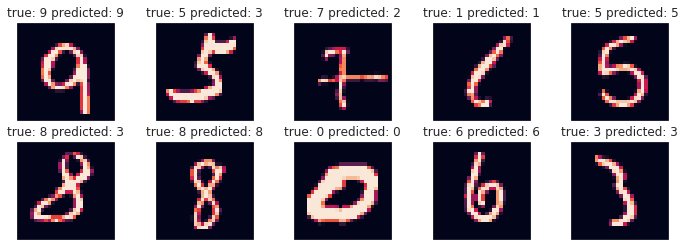

In [568]:
correct, total = test_accuracy(model_sdt, tst_dloader)
print("Total Accuracy: ", 100*sum(correct) / sum(total))
for i in range(10):
    print(f"Accuracy for class {i}: {100*correct[i]/total[i]}")
    
x, y = next(iter(tst_dloader))
fig, ax = show_predictions(model_sdt, x[:10], y[:10])

In [262]:
def plot_sdt_distributions(full_distwe):
    batch_idx = 0
    n_labels = multi_pred[batch_idx][0][1].shape[-1]
    n_node_pairs = 2*len(multi_pred[batch_idx])
    for i in range(n_node_pairs):
        pass